# Retention для Organic и Ads источников (sources)

В данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик **source = 'ads'**, и те, кто пришел через органические каналы **source = 'organic'**.

**Задача** — проанализировать и сравнить **Retention** этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей. 

## Organic

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query_organic = '''
SELECT start_date, date, count(user_id) as active_users 

FROM

(SELECT user_id, min(toDate(time)) as start_date
FROM simulator_20230620.feed_actions 
GROUP BY user_id
HAVING start_date >= today() - 20
) t1

JOIN 

(SELECT distinct(user_id), toDate(time) as date 
FROM simulator_20230620.feed_actions
WHERE source = 'organic') t2

USING (user_id)

GROUP BY date, start_date
ORDER BY start_date, date

'''

df_organic = ph.read_clickhouse(query_organic, connection=connection)
df_organic.head()

,start_date,date,active_users
0,2023-06-13,2023-06-13,756
1,2023-06-13,2023-06-14,256
2,2023-06-13,2023-06-15,260
3,2023-06-13,2023-06-16,232
4,2023-06-13,2023-06-17,228


## Ads

In [2]:
query_ads = '''
SELECT start_date, date, count(user_id) as active_users 

FROM

(SELECT user_id, min(toDate(time)) as start_date
FROM simulator_20230620.feed_actions 
GROUP BY user_id
HAVING start_date >= today() - 20
) t1

JOIN 

(SELECT distinct(user_id), toDate(time) as date 
FROM simulator_20230620.feed_actions
WHERE source = 'ads') t2

USING (user_id)

GROUP BY date, start_date
ORDER BY start_date, date

'''

df_ads = ph.read_clickhouse(query_ads, connection=connection)
df_ads.head()

,start_date,date,active_users
0,2023-06-13,2023-06-13,3688
1,2023-06-13,2023-06-14,106
2,2023-06-13,2023-06-15,124
3,2023-06-13,2023-06-16,122
4,2023-06-13,2023-06-17,108


## Напишем функцию, которая выдаст абсолютные значения Retention в виде таблицы, и в процентах - в виде heatmap.

In [3]:
def retention_heatmap(df, start_date, date, name):
    df['day_of_using'] = (df['date'] - df['start_date']).dt.days + 1
    
    cohorts = pd.pivot_table(index='start_date', columns='day_of_using', values= 'active_users', data=df)
                         
    
    retentions = cohorts.divide(cohorts[1], axis=0) 
    retentions = retentions.round(2)
    
    plt.figure(figsize= (24,14))
    ax = sns.heatmap(retentions, annot=True, 
                 fmt='0.1%', cmap ='YlGnBu')
    ax.set_yticklabels(cohorts.index.strftime('%Y-%m-%d'))
    plt.xlabel("Порядковый номер дня пользования приложением")
    plt.ylabel("Дата первого пользования приложением")
    plt.title(name)
    
    return(cohorts, ax)
    

## Heatmap для organic трафик

(day_of_using      1      2      3      4      5      6      7      8      9   \
 start_date                                                                     
 2023-06-13     756.0  256.0  260.0  232.0  228.0  227.0  212.0  199.0  188.0   
 2023-06-14     729.0  211.0  176.0  182.0  180.0  169.0  170.0  135.0  111.0   
 2023-06-15    1086.0  433.0  400.0  395.0  365.0  338.0  361.0  266.0  292.0   
 2023-06-16    1183.0  499.0  495.0  471.0  462.0  450.0  354.0  384.0  371.0   
 2023-06-17    1310.0  686.0  663.0  639.0  597.0  455.0  572.0  535.0  472.0   
 2023-06-18    1120.0  537.0  492.0  473.0  381.0  448.0  431.0  402.0  368.0   
 2023-06-19    1129.0  555.0  502.0  388.0  509.0  456.0  450.0  411.0  388.0   
 2023-06-20     725.0  243.0  180.0  239.0  204.0  219.0  202.0  205.0  166.0   
 2023-06-21     668.0  148.0  198.0  154.0  168.0  156.0  143.0  143.0  136.0   
 2023-06-22     867.0  347.0  324.0  323.0  285.0  259.0  268.0  292.0  242.0   
 2023-06-23    1246.0  541.0

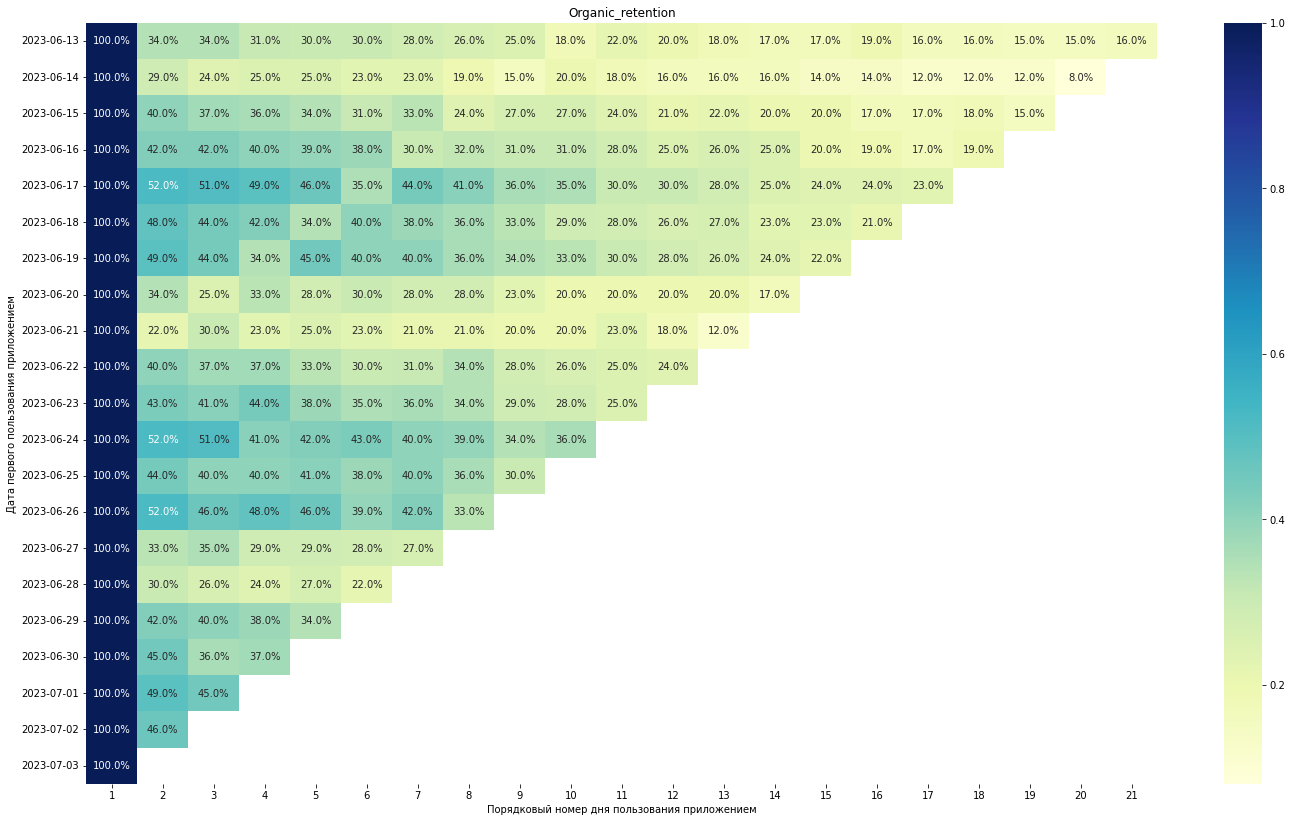

In [4]:
retention_heatmap(df_organic, 'start_date', 'date', 'Organic_retention')

## Heatmap для ads трафик

(day_of_using      1      2      3      4      5      6      7      8      9   \
 start_date                                                                     
 2023-06-13    3688.0  106.0  124.0  122.0  108.0  123.0   93.0   84.0   88.0   
 2023-06-14     586.0  136.0  131.0  111.0  110.0   88.0   84.0  104.0   65.0   
 2023-06-15     883.0  316.0  299.0  276.0  220.0  229.0  229.0  153.0  173.0   
 2023-06-16    1092.0  415.0  388.0  386.0  363.0  333.0  235.0  279.0  285.0   
 2023-06-17    1192.0  555.0  457.0  443.0  480.0  328.0  378.0  371.0  342.0   
 2023-06-18    1039.0  416.0  389.0  372.0  257.0  322.0  304.0  300.0  266.0   
 2023-06-19    1065.0  476.0  436.0  332.0  346.0  382.0  306.0  314.0  276.0   
 2023-06-20     708.0  172.0  135.0  172.0  157.0  134.0  147.0  149.0  132.0   
 2023-06-21     605.0  115.0  146.0  129.0  102.0  107.0  104.0  116.0   93.0   
 2023-06-22     770.0  284.0  225.0  239.0  215.0  216.0  204.0  206.0  182.0   
 2023-06-23    1234.0  429.0

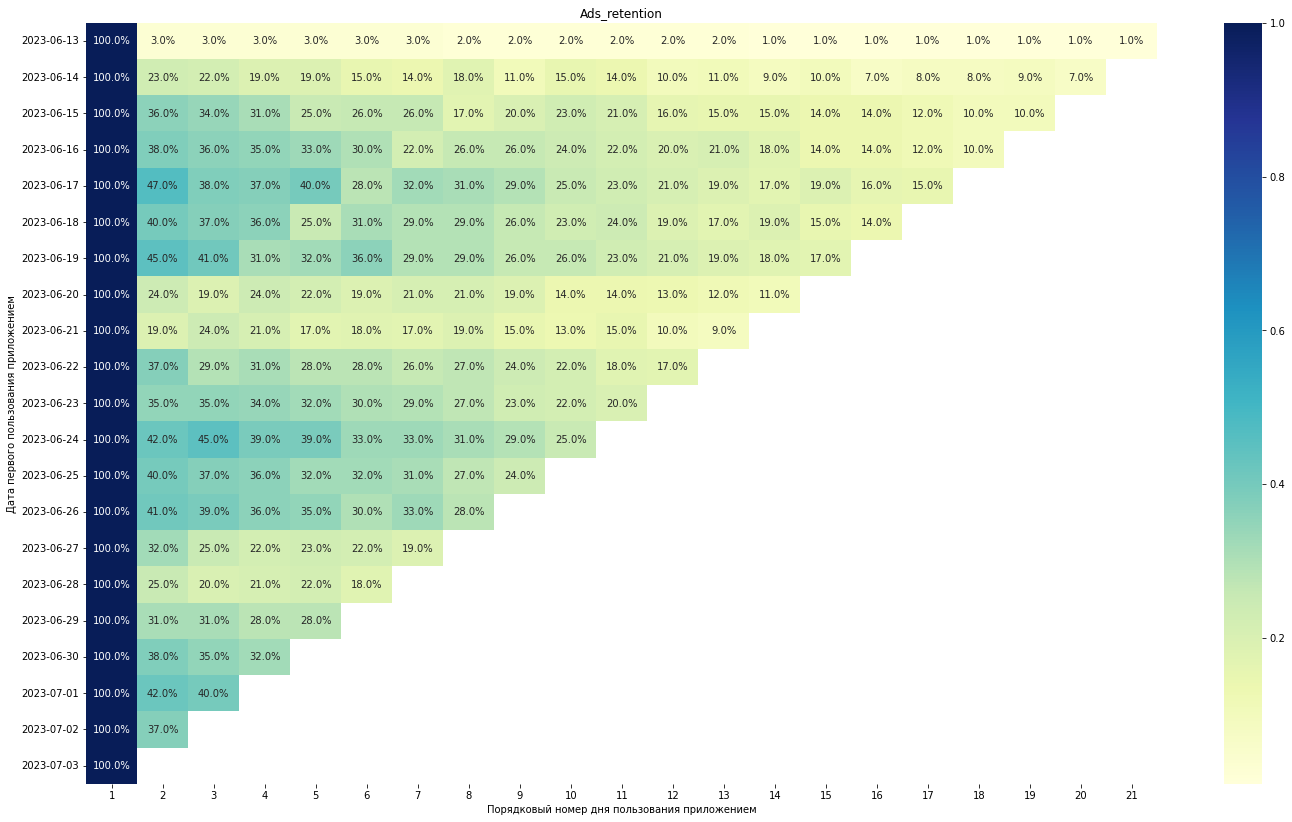

In [5]:
retention_heatmap(df_ads, 'start_date', 'date', 'Ads_retention')

## Разница между retention у Ads и Organic

In [13]:
c1 = pd.pivot_table(index='start_date', columns='day_of_using', values= 'active_users', data=df_organic) 
c2 = pd.pivot_table(index='start_date', columns='day_of_using', values= 'active_users', data=df_ads)

r1 = c1.divide(c1[1], axis=0)*100
r2 = c2.divide(c2[1], axis=0)*100


In [16]:
mean_for_cohorts = r1.subtract(r2).mean(axis=1) #между когортами
mean_for_cohorts

start_date
2023-06-13    19.321563
2023-06-14     4.593253
2023-06-15     5.226802
2023-06-16     5.746533
2023-06-17     7.931495
2023-06-18     6.801768
2023-06-19     6.199978
2023-06-20     6.594181
2023-06-21     4.689654
2023-06-22     4.851244
2023-06-23     6.008229
2023-06-24     6.241583
2023-06-25     5.654970
2023-06-26     8.192205
2023-06-27     5.669445
2023-06-28     3.703704
2023-06-29     6.926513
2023-06-30     3.161139
2023-07-01     4.113912
2023-07-02     4.723465
2023-07-03     0.000000
dtype: float64

In [15]:
overall_mean = mean_for_cohorts.mean() #среднее значение разницы в retention
overall_mean

6.016744471881248

## Сравнение

(1) Если сравнивать абсолютные значения, можно заметить, что в некоторые дни, например, 13 июня, 
число людей приходящих в приложение из-за рекламы во много раз выше (3688 vs 756). 
Однако именно в этой когорте коэффициенты удержания самые низкие, уже на второй день, осталось лишь 3% из пришедших, 
а начиная с четырнадцатого дня - остался лишь 1 %.

-----

(2) На графиках даже при беглом взгляде по цветам видно, что разница есть. 

* Ads - "желтее",  в Organic - больше голубых и зеленых значений. Это говорит о том, что органический трафик более лояльный и его коэффицент удержания выше. 

* На второй и третий день значение в 50% от первого дня можно увидеть только в группе Organic.

* Уже после тринадцатого дня, в группе Ads не встретить значения >= 20%. В группе Oraganic - после  семнадцатого.

-----

Итог:

Разница в коэффициенте удержания между группами явно есть, хотя и не очень большая. Средняя разница в коэффициентах - около 6 %.